In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [98]:
df = pd.read_csv('/home/tukai/Desktop/Template/Churn_Modelling.csv', delimiter=',')
#Shuffle the data and reset the index
df = shuffle(df).reset_index(drop = True) 
print(f'Shape of DF : {df.shape}\n\nData Types:\n{df.dtypes}\n\nChecking Null Values:\n\n{df.isnull().sum()}\n\nUnique values for each feature vectors:\n\n{df.nunique()}')

Shape of DF : (10000, 14)

Data Types:
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Checking Null Values:

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Unique values for each feature vectors:

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure               

<p>Dropping columns</p>

In [56]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace=True)

In [57]:
print(df.shape)
df.head()

(10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


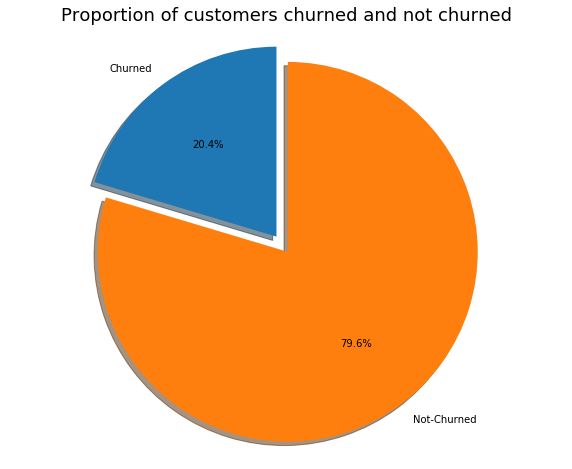

In [58]:
labels = 'Churned', 'Not-Churned'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize = (10, 8))
ax1.pie(sizes, explode = explode, labels = labels, shadow = True, startangle = 90, autopct='%1.1f%%')
ax1.axis('equal')
plt.title('Proportion of customers churned and not churned', size=18)
plt.show()

<p>Plot target variable using bar plots</p>

Text(0, 0.5, 'Percentage')

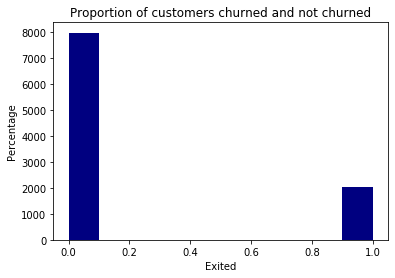

In [59]:
df['Exited'].plot.hist(title='Proportion of customers churned and not churned', colormap='jet')
plt.xlabel('Exited')
plt.ylabel('Percentage')

<p>Exploratory Data Analysis</p>

<p>For categorical data</p>

           Exited
Geography        
France       5014
Germany      2509
Spain        2477


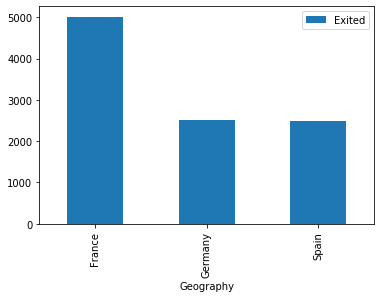

In [60]:
pivot = pd.pivot_table(df, values='Exited', index=['Geography'], aggfunc='count')
print(pivot)
pivot.plot(kind='bar')

Text(0, 0.5, 'count')

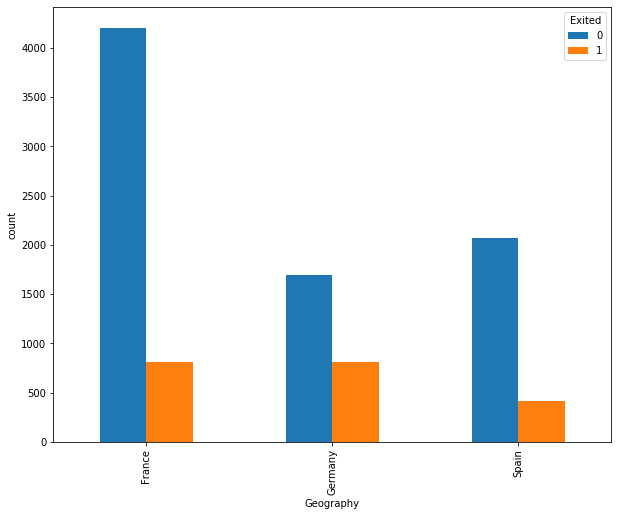

In [61]:
df.groupby(['Geography', 'Exited']).size().unstack(fill_value=0).plot(kind='bar', figsize=(10,8))
plt.ylabel('count')

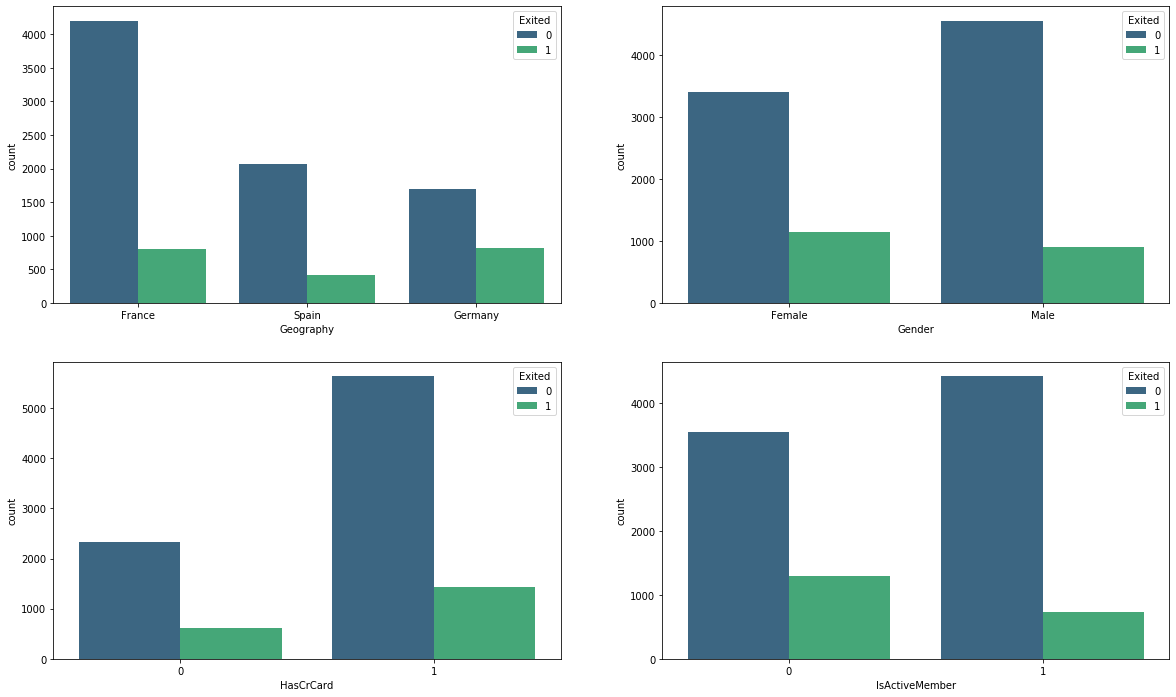

In [62]:
fig, axarr = plt.subplots(2,2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0], palette = 'viridis')
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1], palette = 'viridis')
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0], palette = 'viridis')
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1], palette = 'viridis')

<p>For Continuous data</p>

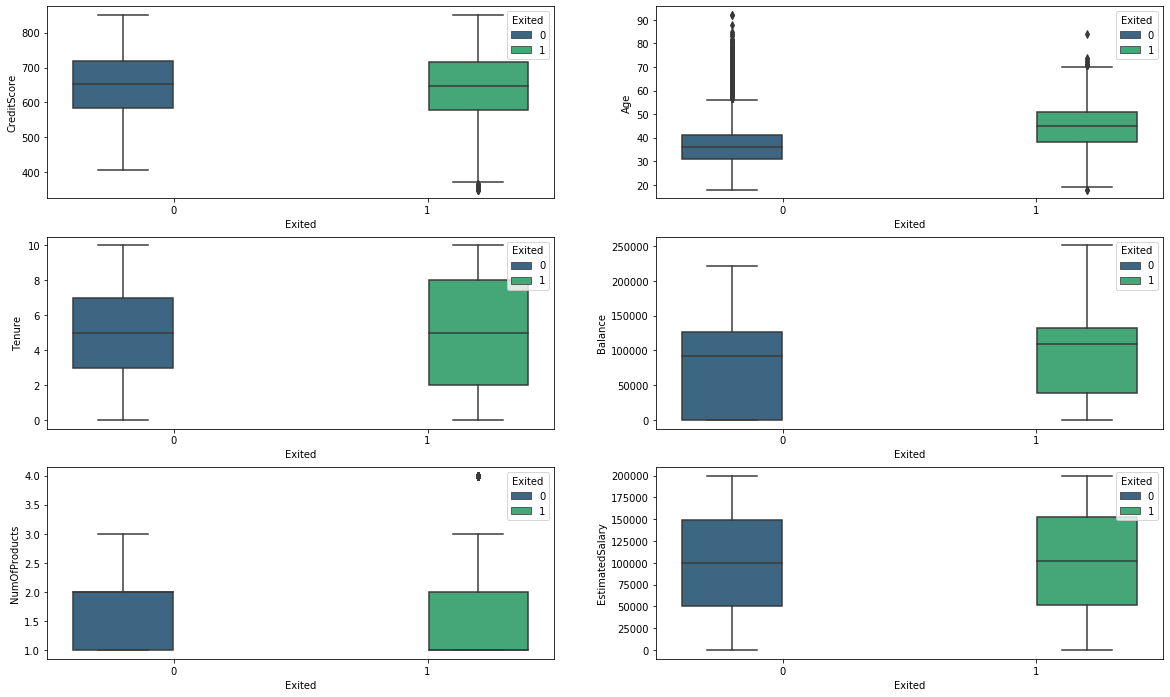

In [63]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0], palette = 'viridis')
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1], palette = 'viridis')
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0], palette = 'viridis')
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1], palette = 'viridis')
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0], palette = 'viridis')
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1], palette = 'viridis')

<p>Feature Engineering

<p>Train Test Split

In [64]:
df_train = df.sample(frac=0.75,random_state=200)
df_test = df.drop(df_train.index)
print(len(df_train))
print(len(df_test))

7500
2500


<p>Adding Features</p>

(-5, 10)

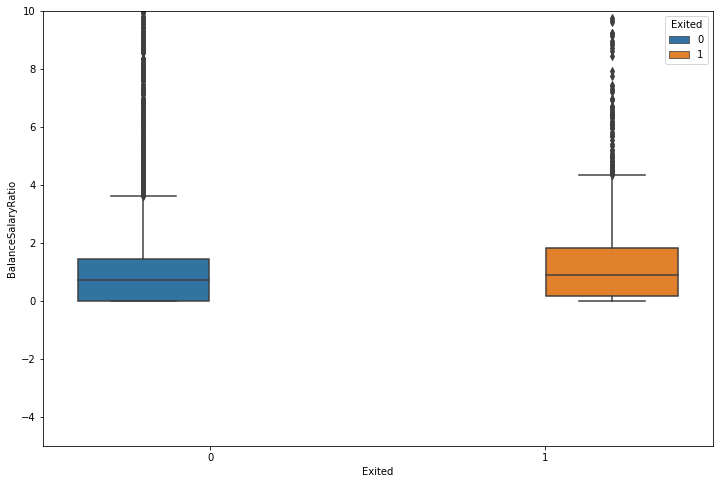

In [65]:
plt.subplots(figsize=(12,8))
df_train['BalanceSalaryRatio'] = df_train.Balance/df_train.EstimatedSalary
sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-5, 10)

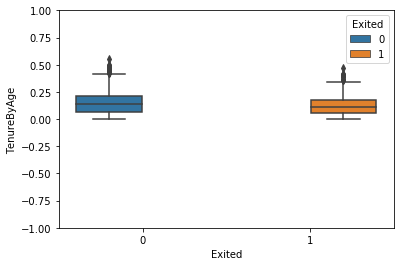

In [66]:
# Given that tenure is a 'function' of age, we introduce a variable aiming to standardize tenure over age:
df_train['TenureByAge'] = df_train.Tenure/(df_train.Age)
sns.boxplot(y='TenureByAge',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-1, 1)
plt.show()
df_train['CreditScoreGivenAge'] = df_train.CreditScore/(df_train.Age)

<p><b>TRAINING Data prep for model fitting</p>

In [67]:
# Arrange columns by data type for easier manipulation
continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary', 'BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']
df_train = df_train[['Exited'] + continuous_vars + cat_vars]
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,Spain,Female
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,France,Female
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,0,France,Female
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,Germany,Male
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,0,1,France,Male


In [68]:
# One hot encode the categorical variables
lst = ['Geography', 'Gender']
remove = list()
for i in lst:
    if (df_train[i].dtype == np.str or df_train[i].dtype == np.object):
        for j in df_train[i].unique():
            df_train[i+'_'+j] = np.where(df_train[i] == j,1,0)
        remove.append(i)
df_train = df_train.drop(remove, axis=1)
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_Spain,Geography_France,Geography_Germany,Gender_Female,Gender_Male
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,1,0,0,1,0
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,0,1,0,1,0
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,0,0,1,0,1,0
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,0,0,1,0,1
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,0,1,0,1,0,0,1


In [17]:
'''For the one hot variables, we change 0 to -1 so that the models can capture a negative relation 
where the attribute in inapplicable instead of 0'''
df_train.loc[df_train.HasCrCard == 0, 'HasCrCard'] = -1
df_train.loc[df_train.IsActiveMember == 0, 'IsActiveMember'] = -1
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_Spain,Geography_France,Geography_Germany,Gender_Female,Gender_Male
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,1,-1,-1,1,-1
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,-1,1,-1,1,-1
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,-1,-1,1,-1,1,-1
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,-1,-1,1,-1,1
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,-1,1,-1,1,-1,-1,1


<p><b>Min-Max Scaling

In [18]:
# minMax scaling the continuous variables
minVec = df_train[continuous_vars].min().copy()
maxVec = df_train[continuous_vars].max().copy()
df_train[continuous_vars] = (df_train[continuous_vars]-minVec)/(maxVec-minVec)
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_Spain,Geography_France,Geography_Germany,Gender_Female,Gender_Male
8159,0,0.222,0.094595,0.6,0.000000,0.333333,0.076118,0.000000,0.432000,0.323157,1,1,1,-1,-1,1,-1
6332,0,0.538,0.229730,0.4,0.360358,0.000000,0.102376,0.003317,0.205714,0.305211,1,1,-1,1,-1,1,-1
8895,0,0.698,0.297297,0.8,0.486406,0.000000,0.510225,0.000901,0.360000,0.300198,1,-1,-1,1,-1,1,-1
5351,0,0.416,0.310811,0.2,0.495130,0.000000,0.555744,0.000843,0.087805,0.208238,1,1,-1,-1,1,-1,1
4314,0,0.576,0.216216,0.5,0.532094,0.000000,0.778145,0.000647,0.264706,0.330882,-1,1,-1,1,-1,-1,1


<p><b>TEST data preparation</p>

In [19]:
# data prep pipeline for test data
def DfPrepPipeline(df_predict,df_train_Cols,minVec,maxVec):
    # Add new features
    df_predict['BalanceSalaryRatio'] = df_predict.Balance/df_predict.EstimatedSalary
    df_predict['TenureByAge'] = df_predict.Tenure/(df_predict.Age - 18)
    df_predict['CreditScoreGivenAge'] = df_predict.CreditScore/(df_predict.Age - 18)
    # Reorder the columns
    continuous_vars = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
    cat_vars = ['HasCrCard','IsActiveMember',"Geography", "Gender"] 
    df_predict = df_predict[['Exited'] + continuous_vars + cat_vars]
    # Change the 0 in categorical variables to -1
    df_predict.loc[df_predict.HasCrCard == 0, 'HasCrCard'] = -1
    df_predict.loc[df_predict.IsActiveMember == 0, 'IsActiveMember'] = -1
    # One hot encode the categorical variables
    lst = ["Geography", "Gender"]
    remove = list()
    for i in lst:
        for j in df_predict[i].unique():
            df_predict[i+'_'+j] = np.where(df_predict[i] == j,1,-1)
        remove.append(i)
    df_predict = df_predict.drop(remove, axis=1)
    # Ensure that all one hot encoded variables that appear in the train data appear in the subsequent data
    L = list(set(df_train_Cols) - set(df_predict.columns))
    for l in L:
        df_predict[str(l)] = -1        
    # MinMax scaling coontinuous variables based on min and max from the train data
    df_predict[continuous_vars] = (df_predict[continuous_vars]-minVec)/(maxVec-minVec)
    # Ensure that The variables are ordered in the same way as was ordered in the train set
    df_predict = df_predict[df_train_Cols]
    return df_predict

<b>Model fitting and selection</b><br> </br>
For the model fitting, I will try out the following
1. Logistic regression in the primal space and with different kernels
2. SVM in the primal and with different Kernels
3. Ensemble models

In [71]:
# Support functions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# Fit models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Scoring functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [21]:
# Function to give best model score and parameters
def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)

In [22]:
# Fit logistic regression with degree 2 polynomial kernel
param_grid = {'C': [0.1,10,50], 'max_iter': [300,500], 'fit_intercept':[True],'intercept_scaling':[1],'penalty':['l2'],
              'tol':[0.0001,0.000001]}
poly2 = PolynomialFeatures(degree=2)
df_train_pol2 = poly2.fit_transform(df_train.loc[:, df_train.columns != 'Exited'])
log_pol2_Grid = GridSearchCV(LogisticRegression(solver = 'liblinear'),param_grid, cv=5, refit=True, verbose=0)
log_pol2_Grid.fit(df_train_pol2,df_train.Exited)
best_model(log_pol2_Grid)

0.8565333333333334
{'C': 50, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 300, 'penalty': 'l2', 'tol': 0.0001}
LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [23]:
# Fit SVM with RBF Kernel
param_grid = {'C': [0.5,100,150], 'gamma': [0.1,0.01,0.001],'probability':[True],'kernel': ['rbf']}
SVM_grid = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=0)
SVM_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(SVM_grid)

0.8517333333333333
{'C': 150, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
SVC(C=150, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [24]:
# Fit SVM with pol kernel
param_grid = {'C': [0.5,1,10,50,100], 'gamma': [0.1,0.01,0.001],'probability':[True],'kernel': ['poly'],'degree':[2,3] }
SVM_pol_grid = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=0)
SVM_pol_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(SVM_pol_grid)

0.8544
{'C': 100, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly', 'probability': True}
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=0.1, kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [25]:
# Fit random forest classifier
param_grid = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [2,4,6,7,8,9],'n_estimators':[50,100],'min_samples_split': [3, 5, 6, 7]}
RanFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, refit=True, verbose=0)
RanFor_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(RanFor_grid)

0.864
{'max_depth': 8, 'max_features': 7, 'min_samples_split': 6, 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features=7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [26]:
# Fit Extreme Gradient boosting classifier
param_grid = {'max_depth': [5,6,7,8], 'gamma': [0.01,0.001,0.001],'min_child_weight':[1,5,10], 'learning_rate': [0.05,0.1, 0.2, 0.3], 'n_estimators':[5,10,20,100]}
xgb_grid = GridSearchCV(XGBClassifier(), param_grid, cv=5, refit=True, verbose=0)
xgb_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(xgb_grid)

0.8638666666666667
{'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


<p><b>Fitting best models</b><br></p>

In [27]:
# Fitting logistic regression with poly 2 kernel
poly2 = PolynomialFeatures(degree=2)
df_train_pol2 = poly2.fit_transform(df_train.loc[:, df_train.columns != 'Exited'])
log_pol2 = LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
log_pol2.fit(df_train_pol2, df_train.Exited)

LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
# Fit SVM with RBF Kernel
SVM_RBF = SVC(C=150, cache_size=200, class_weight=None, coef0=0.0,
                decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
                max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
                verbose=False)
SVM_RBF.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

SVC(C=150, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [29]:
# Fit SVM with Pol Kernel
SVM_pol = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
                decision_function_shape='ovr', degree=2, gamma=0.1, kernel='poly',
                max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
                verbose=False)
SVM_pol.fit(df_train.loc[:, df_train.columns != 'Exited'], df_train.Exited)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=0.1, kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [30]:
# Fit Random Forest Classifier
RF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
RF.fit(df_train.loc[:, df_train.columns != 'Exited'], df_train.Exited)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
# Fit Extreme Gradient Boosting Classifier 
XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
XGB.fit(df_train.loc[:, df_train.columns != 'Exited'], df_train.Exited)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

<p><b> Review best model fit accuracy : Keen interest is on the performance in predicting 1's - Customers who actually churn</p>

<p> Logistic Regression with Polynomial Kernel

In [32]:
print(classification_report(df_train.Exited, log_pol2.predict(df_train_pol2)))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      5950
           1       0.76      0.49      0.59      1550

    accuracy                           0.86      7500
   macro avg       0.82      0.72      0.76      7500
weighted avg       0.85      0.86      0.85      7500



<p>SVM with RBF

<p>SVM with Poly Kernel</p>

In [33]:
print(classification_report(df_train.Exited, SVM_pol.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      5950
           1       0.84      0.38      0.52      1550

    accuracy                           0.86      7500
   macro avg       0.85      0.68      0.72      7500
weighted avg       0.85      0.86      0.83      7500



<p>Random Forest</p>

In [34]:
print(classification_report(df_train.Exited, RF.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      5950
           1       0.88      0.54      0.67      1550

    accuracy                           0.89      7500
   macro avg       0.89      0.76      0.80      7500
weighted avg       0.89      0.89      0.88      7500



<p>Extreme Gradient Boosting</p>

In [35]:
print(classification_report(df_train.Exited,  XGB.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      5950
           1       0.84      0.57      0.68      1550

    accuracy                           0.89      7500
   macro avg       0.87      0.77      0.80      7500
weighted avg       0.89      0.89      0.88      7500



<p>Plotting ROC Curves

In [36]:
y = df_train.Exited
X = df_train.loc[:, df_train.columns != 'Exited']
X_pol2 = df_train_pol2
auc_log_pol2, fpr_log_pol2, tpr_log_pol2 = get_auc_scores(y, log_pol2.predict(X_pol2), 
                                                          log_pol2.predict_proba(X_pol2)[:, 1])
auc_SVM_RBF, fpr_SVM_RBF, tpr_SVM_RBF = get_auc_scores(y, SVM_RBF.predict(X), 
                                                       SVM_RBF.predict_proba(X)[:, 1])
auc_SVM_POL, fpr_SVM_POL, tpr_SVM_POL = get_auc_scores(y, SVM_pol.predict(X),
                                                       SVM_pol.predict_proba(X)[:, 1]) 
auc_RF, fpr_RF, tpr_RF = get_auc_scores(y, RF.predict(X), RF.predict_proba(X)[:, 1])
auc_XGB, fpr_XGB, tpr_XGB = get_auc_scores(y, XGB.predict(X), XGB.predict_proba(X)[:, 1])

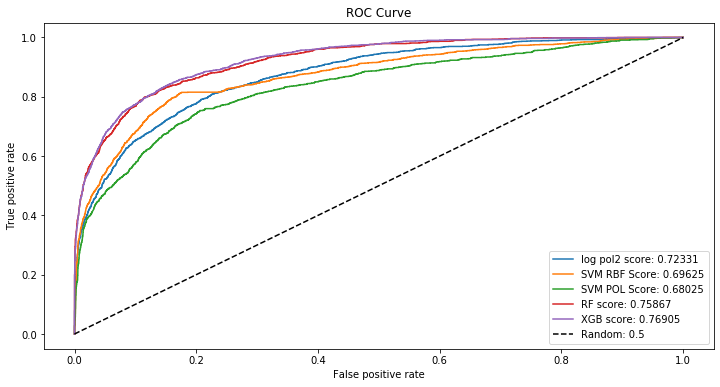

In [37]:
plt.figure(figsize=(12,6), linewidth = 1)
plt.plot(fpr_log_pol2, tpr_log_pol2, label = 'log pol2 score: ' + str(round(auc_log_pol2, 5)))
plt.plot(fpr_SVM_RBF, tpr_SVM_RBF, label = 'SVM RBF Score: ' + str(round(auc_SVM_RBF, 5)))
plt.plot(fpr_SVM_POL, tpr_SVM_POL, label = 'SVM POL Score: ' + str(round(auc_SVM_POL, 5)))
plt.plot(fpr_RF, tpr_RF, label = 'RF score: ' + str(round(auc_RF, 5)))
plt.plot(fpr_XGB, tpr_XGB, label = 'XGB score: ' + str(round(auc_XGB, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

<p>Reason behid taking one particular classification algorithm</p>

<p>Test model prediction on Test Data</p>

In [38]:
# Make the transformations for Test Data
df_test = DfPrepPipeline(df_test, df_train.columns, minVec, maxVec)
df_test = df_test.mask(np.isinf(df_test))
df_test = df_test.dropna()
df_test.shape

(2495, 17)

In [39]:
print(classification_report(df_test.Exited,  
                            RF.predict(df_test.loc[:, df_test.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2009
           1       0.76      0.42      0.54       486

    accuracy                           0.86      2495
   macro avg       0.82      0.69      0.73      2495
weighted avg       0.85      0.86      0.85      2495



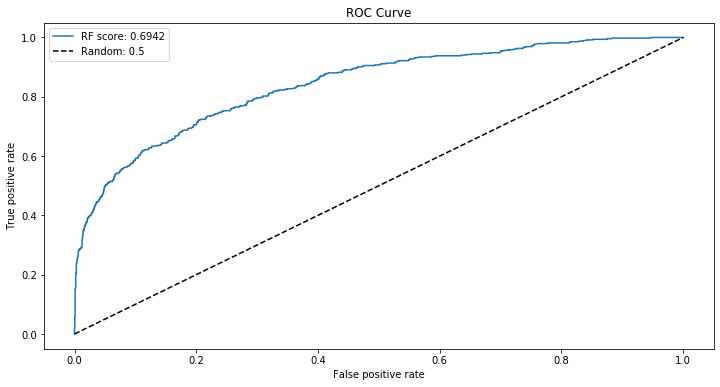

In [41]:
auc_RF_test, fpr_RF_test, tpr_RF_test = get_auc_scores(df_test.Exited, RF.predict(df_test.loc[:, df_test.columns != 'Exited']),
                                                       RF.predict_proba(df_test.loc[:, df_test.columns != 'Exited'])[:,1])
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_RF_test, tpr_RF_test, label = 'RF score: ' + str(round(auc_RF_test, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

<p><b><h1>Important Snippets</b><br></h1>
<p><b> Select K Best Features

I am getting two different sets of p-values when I use scikit learn's

Type I
predKbest= SelectKBest(sklearn.feature_selection.f_regression, k=i).fit(X_train, y_train)
predKbest.pvalues_

Type II
predKbest= SelectKBest(sklearn.feature_selection.chi2, k=i).fit(X_train, y_train)    
predKbest.pvalues_

EXPLANATION: 
SelectKBest will select, in your case, the top i variables by importance, based on the test that you input : Fischer or Chi2.

F_regression is used for regression while chi2 is used for classification so it's quite strange that you use both of them with the same input variables. You should take a step back and study what you really are looking to do. Everything is well explained here : http://scikit-learn.org/stable/modules/feature_selection.html
f_regression p_value wil calculate the linear dependancy between each regressor and the target.

chi2 test "measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification." X must contains non-negative features such as booleans or frequencies.

The p_values that you print are here the results of the chi2 and f_regression that are "transformed" into p_values, so it's 100% normal that they are different.

In [84]:
from sklearn.feature_selection import SelectKBest, chi2
pd.options.display.float_format = '{:.2f}'.format

X = df_train.iloc[:,df_train.columns != 'Exited']  #independent columns
y = df_train.iloc[:,df_train.columns == 'Exited']    #target column i.e Exited

# Apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2)
fit = bestfeatures.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

featureScores
print(featureScores.nlargest(12,'Score'))  #print 10 best features

                  Specs      Score
3               Balance 5384341.68
5       EstimatedSalary   48712.53
1                   Age    1737.15
6    BalanceSalaryRatio    1364.96
8   CreditScoreGivenAge     801.49
13    Geography_Germany     165.02
0           CreditScore     109.71
10       IsActiveMember      99.06
14        Gender_Female      54.07
15          Gender_Male      45.23
12     Geography_France      37.38
11      Geography_Spain      17.67


<p><b>Feature Importance based on Tree Classifier</b><br>
You can get the feature importance of each feature of your dataset by using the feature importance property of the model.<br>
Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.<br>
Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.

/home/tukai/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/tukai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


[0.08614686 0.15501528 0.06647772 0.08793249 0.12674614 0.0827458
 0.06792714 0.08445243 0.12131111 0.02515955 0.03558942 0.01099257
 0.01100853 0.02235584 0.00734662 0.00879249]


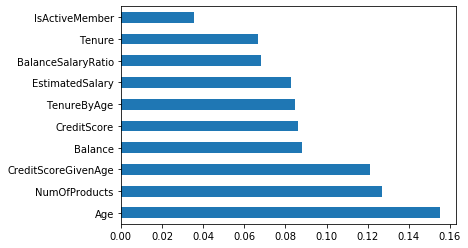

In [86]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)

#use inbuilt class feature_importances of tree based classifiers
print(model.feature_importances_) 
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

<b>Heat Map</b>

In [ ]:
def show_correlations(dataframe, show_chart = True):
    fig = plt.figure(figsize = (20,10))
    corr = dataframe.corr()
    if show_chart == True:
        sns.heatmap(corr, 
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values,
                    annot=True)
    return corr

correlation_df = show_correlations(df2,show_chart=True)

<p><b>Convert all yes and no to 0's & 1's so our classifier can use this data.</p>

In [ ]:
columns_to_convert = ['Partner', 
                      'Dependents', 
                      'PhoneService', 
                      'PaperlessBilling', 
                      'Churn']

for item in columns_to_convert:
    df[item].replace(to_replace='yes', value=1, inplace=True)
    df[item].replace(to_replace='no',  value=0, inplace=True)
df.head()

<p><b>Convert strings to lowercase</p>

In [ ]:
for item in df.columns:
    try:
        df[item] = df[item].str.lower()
    except:
        print(item, "couldn't convert")
df.head()

<p><b>View the unique data by column</p>

In [ ]:
for item in df.columns:
    print(item)
    print (df[item].unique())

<p><b>Variable Selection

<p>Categorical Variables

In [88]:
# find categorical variables
categorical = [var for var in df.columns if df[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))
# view of categorical variables
df[categorical].head()

There are 2 categorical variables


,Geography,Gender
0,France,Female
1,Spain,Female
2,France,Female
3,France,Female
4,Spain,Female


<p>Continuous/Discrete Variables

In [91]:
# find numerical variables
numerical = [var for var in df.columns if df[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))
# view of categorical variables
df[numerical].head()

There are 9 numerical variables


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,42,2,0.00,1,1,1,101348.88,1
1,608,41,1,83807.86,1,0,1,112542.58,0
2,502,42,8,159660.80,3,1,0,113931.57,1
3,699,39,1,0.00,2,0,0,93826.63,0
4,850,43,2,125510.82,1,1,1,79084.10,0


2 continuous variables - Balance and Estimated Salary.<br>
4 discrete variables - Credit Score, Age, Tenure, NoOfProducts.<br>
3 boolean variables - NoOfProducts, HasCard, IsActiveMembers and Exited.<br>

In [93]:
# let's visualise the values of the discrete variables
for var in numerical:
    print(var, ' values: ', df[var].unique())

CreditScore  values:  [619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771
 681 544 696 766 727 693 557 531 498 651 791 733 811 707 714 782 775 799
 602 744 588 747 583 627 731 629 438 642 806 474 559 429 680 749 734 644
 626 649 805 718 840 630 654 762 568 613 522 737 648 443 640 540 460 593
 801 611 802 745 483 690 492 

<p><b>Missing values

In [94]:
# let's visualise the percentage of missing values
df.isnull().mean()

CreditScore       0.00
Geography         0.00
Gender            0.00
Age               0.00
Tenure            0.00
Balance           0.00
NumOfProducts     0.00
HasCrCard         0.00
IsActiveMember    0.00
EstimatedSalary   0.00
Exited            0.00
dtype: float64

<p><b>Outliers<br> Continuous variables</b><br>Using 3 sigma range and Z score

In [115]:
from scipy import stats
df_train = df_train[(np.abs(stats.zscore(df_train)) < 3).all(axis=1)]
len(df_train)

6598

<p>Box plot to identify outliers

Text(0, 0.5, 'EstimatedSalary')

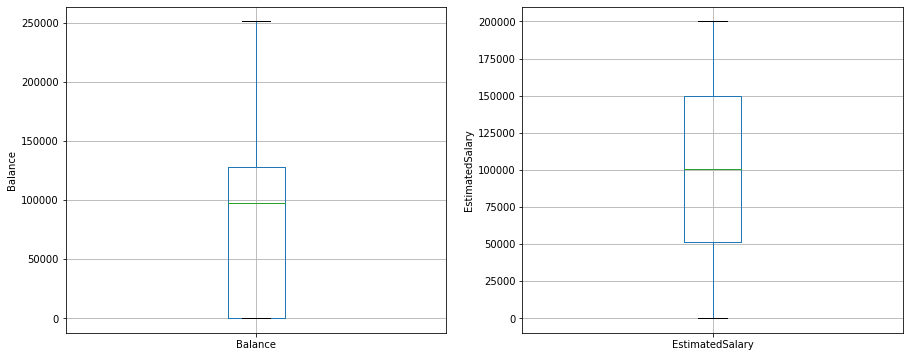

In [108]:
# let's make boxplots to visualise outliers in the continuous variables 
# Age and Fare

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = df.boxplot(column='Balance')
fig.set_title('')
fig.set_ylabel('Balance')

plt.subplot(1, 2, 2)
fig = df.boxplot(column='EstimatedSalary')
fig.set_title('')
fig.set_ylabel('EstimatedSalary')

Text(0.5, 0, 'Estimated Salary')

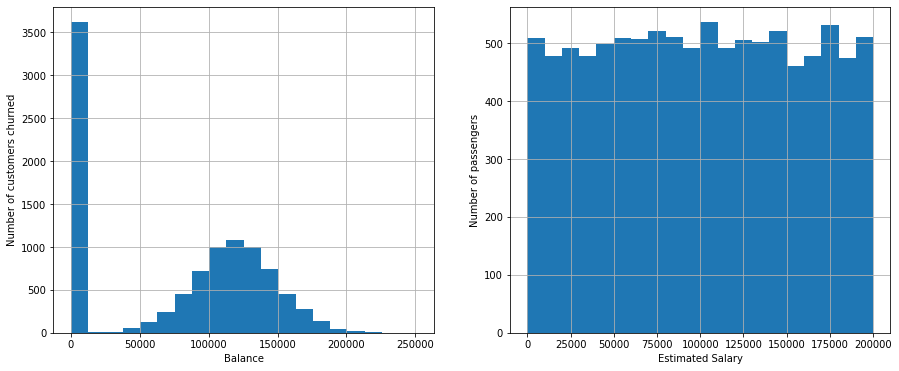

In [110]:
# first we plot the distributions to find out if they are Gaussian or skewed.
# Depending on the distribution, we will use the normal assumption or the interquantile
# range to find outliers

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = df.Balance.hist(bins=20)
fig.set_ylabel('Number of customers churned')
fig.set_xlabel('Balance')

plt.subplot(1, 2, 2)
fig = df.EstimatedSalary.hist(bins=20)
fig.set_ylabel('Number of passengers')
fig.set_xlabel('Estimated Salary')

In [116]:
# find outliers

# Age
Upper_boundary = data.Age.mean() + 3* data.Age.std()
Lower_boundary = data.Age.mean() - 3* data.Age.std()
print('Age outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_boundary, upperboundary=Upper_boundary))

# Fare
IQR = data.Fare.quantile(0.75) - data.Fare.quantile(0.25)
Lower_fence = data.Fare.quantile(0.25) - (IQR * 3)
Upper_fence = data.Fare.quantile(0.75) + (IQR * 3)
print('Fare outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

In [116]:
%whos

Variable                 Type                      Data/Info
------------------------------------------------------------
DfPrepPipeline           function                  <function DfPrepPipeline at 0x7f52f410ce60>
ExtraTreesClassifier     ABCMeta                   <class 'sklearn.ensemble.<...>st.ExtraTreesClassifier'>
GridSearchCV             ABCMeta                   <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
LogisticRegression       type                      <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
PolynomialFeatures       type                      <class 'sklearn.preproces<...>data.PolynomialFeatures'>
RF                       RandomForestClassifier    RandomForestClassifier(bo<...>bose=0, warm_start=False)
RanFor_grid              GridSearchCV              GridSearchCV(cv=5, error_<...> scoring=None, verbose=0)
RandomForestClassifier   ABCMeta                   <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SVC                      ABCMeta  